In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
thetas = np.linspace(0, np.pi/2, 20, endpoint=False)
print(thetas)

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651]


In [7]:
schedules = []

In [64]:
## Standard Way: Cnot RZ Cnot
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(0, 1)
    circuit.rx(theta, 1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

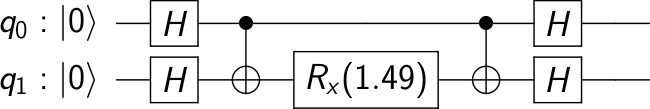

In [65]:
circuit.draw(output='latex')

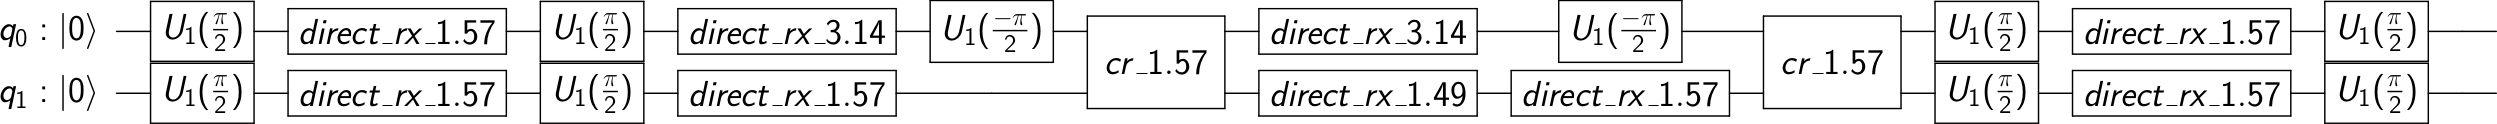

In [66]:
circuit.decompose().draw(output='latex')

In [42]:
## Optimized Way Way: zz_interaction decomposes directly to cross resonancefor theta in thetas:
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.zz_interaction(theta, 0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    schedule |= measure << schedule.duration
    schedules.append(schedule)

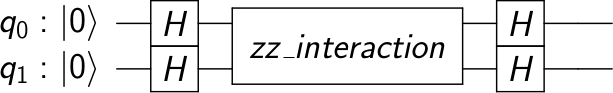

In [43]:
circuit.draw(output='latex')

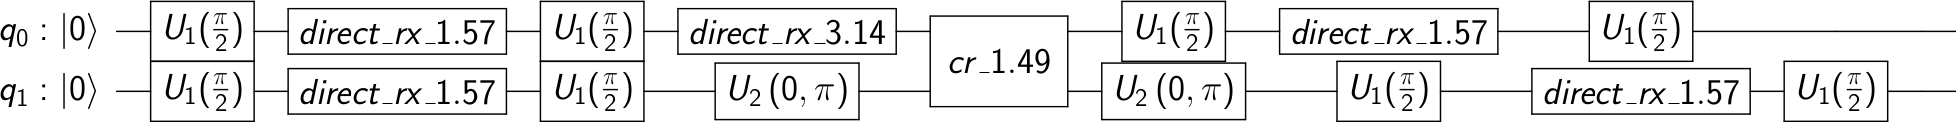

In [44]:
circuit.decompose().draw(output='latex')

In [10]:
shots = 1000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5dd735d0d4872d00185a5603


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [15]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

# Run a mitigation cal job

In [ ]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0])
job_mit = q.execute(meas_qcs, backend, initial_layout=[0,1])

-----
## Analysis

In [16]:
result = job.result()

In [ ]:
# mitigate results
result_mit = job_mit.result()
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels, qubit_list=[0,1])

In [17]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [18]:
standard_counts_list = []
for i in range(len(thetas)):
    counts = marginal_counts(result.get_counts(i), meas_qubits=[0,1])
    counts_mit = readout_fitter.filter.apply(counts)
    standard_counts_list.append(counts_mit)
print(standard_counts_list)

[{'00': 937, '01': 44, '10': 15, '11': 4}, {'00': 933, '01': 48, '10': 16, '11': 3}, {'00': 928, '01': 53, '10': 15, '11': 4}, {'00': 926, '01': 57, '10': 15, '11': 2}, {'00': 942, '01': 34, '10': 18, '11': 6}, {'00': 914, '01': 62, '10': 19, '11': 5}, {'00': 935, '01': 45, '10': 14, '11': 6}, {'00': 936, '01': 44, '10': 16, '11': 4}, {'00': 936, '01': 41, '10': 18, '11': 5}, {'00': 917, '01': 58, '10': 16, '11': 9}, {'00': 923, '01': 64, '10': 7, '11': 6}, {'00': 932, '01': 53, '10': 13, '11': 2}, {'00': 942, '01': 43, '10': 9, '11': 6}, {'00': 943, '01': 41, '10': 14, '11': 2}, {'00': 921, '01': 56, '10': 16, '11': 7}, {'00': 935, '01': 44, '10': 18, '11': 3}, {'00': 944, '01': 37, '10': 13, '11': 6}, {'00': 926, '01': 40, '10': 25, '11': 9}, {'00': 927, '01': 51, '10': 11, '11': 11}, {'00': 915, '01': 56, '10': 20, '11': 9}]


In [24]:
optimized_counts_list = []
for i in range(len(thetas), len(thetas) * 2):
    counts = marginal_counts(result.get_counts(i), meas_qubits=[0,1])
    counts_mit = readout_fitter.filter.apply(counts)
    optimized_counts_list.append(counts_mit)
print(optimized_counts_list)

[{'00': 954, '01': 26, '10': 16, '11': 4}, {'00': 951, '01': 25, '10': 18, '11': 6}, {'00': 943, '01': 32, '10': 15, '11': 10}, {'00': 922, '01': 26, '10': 21, '11': 31}, {'00': 902, '01': 25, '10': 20, '11': 53}, {'00': 865, '01': 39, '10': 24, '11': 72}, {'00': 818, '01': 46, '10': 16, '11': 120}, {'00': 793, '01': 34, '10': 37, '11': 136}, {'00': 768, '01': 37, '10': 38, '11': 157}, {'00': 729, '01': 30, '10': 49, '11': 192}, {'00': 706, '01': 43, '10': 40, '11': 211}, {'00': 650, '01': 49, '10': 42, '11': 259}, {'00': 604, '01': 59, '10': 45, '11': 292}, {'00': 607, '01': 54, '10': 50, '11': 289}, {'00': 586, '01': 48, '10': 42, '11': 324}, {'00': 529, '01': 61, '10': 53, '11': 357}, {'00': 508, '01': 49, '10': 58, '11': 385}, {'00': 552, '01': 42, '10': 52, '11': 354}, {'00': 491, '01': 63, '10': 49, '11': 397}, {'00': 465, '01': 74, '10': 53, '11': 408}]


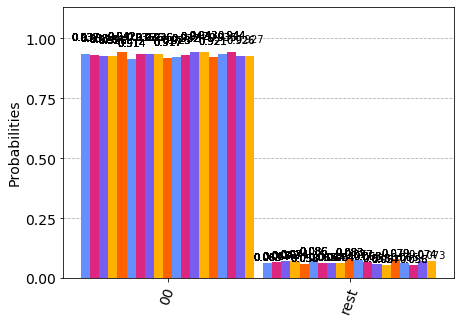

In [63]:
from qiskit.visualization import plot_histogram
plot_histogram(standard_counts_list[:19], number_to_keep=1)

In [ ]:
# # infer output state vectors, up to phase of each element (phase won't matter for overlap calculation)
# standard_state_vectors = []
# for counts in standard_counts_list:
#         standard_state_vectors.append(np.array([
#             np.sqrt(counts.get('00', 0)/shots),
#             np.sqrt(counts.get('01', 0)/shots),
#             np.sqrt(counts.get('10', 0)/shots),
#             np.sqrt(counts.get('11', 0)/shots)]))

In [ ]:
# optimized_state_vectors = []
# for counts in standard_counts_list:
#         standard_state_vectors.append(np.array([
#             np.sqrt(counts.get('00', 0)/shots),
#             np.sqrt(counts.get('01', 0)/shots),
#             np.sqrt(counts.get('10', 0)/shots),
#             np.sqrt(counts.get('11', 0)/shots)]))

In [ ]:
# pranav can add fidelity plotting cells below here